# Model for HackMX NDS Cognitive Labs Challenge
## Fraud Detection
#### Dataset obtained from IEEE-CIS Fraud Detection in Kaggle: 

In [1]:
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import pickle
import time

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold

import lightgbm as lgb

In [2]:
train_identity = "data/train_identity.csv"
train_transaction = "data/train_transaction.csv"
test_identity = "data/test_identity.csv"
test_transaction = "data/test_transaction.csv"

In [6]:
#%%time # visualize time to load data
train_id = pd.read_csv(train_identity)
train_tr = pd.read_csv(train_transaction)
test_id = pd.read_csv(test_identity)
test_tr = pd.read_csv(test_transaction)

In [7]:
def downcast_dtypes(df):
    _start = df.memory_usage(deep=True).sum() / 1024 ** 2
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    _end = df.memory_usage(deep=True).sum() / 1024 ** 2
    saved = (_start - _end) / _start * 100
    print(f"Saved {saved:.2f}%")
    return df

In [8]:
train_id = downcast_dtypes(train_id)
train_tr = downcast_dtypes(train_tr)
test_id = downcast_dtypes(test_id)
test_tr = downcast_dtypes(test_tr)

Saved 8.32%
Saved 40.53%
Saved 8.38%
Saved 40.20%


In [27]:
train_id.to_parquet(f"./data/train_identity.parquet.gzip", compression="gzip")
train_tr.to_parquet(f"./data/train_transaction.parquet.gzip", compression="gzip")
test_id.to_parquet(f"./data/test_identity.parquet.gzip", compression="gzip")
test_tr.to_parquet(f"./data/test_transaction.parquet.gzip", compression="gzip")

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

In [10]:
train = pd.merge(
    train_tr, train_id, how="left", on="TransactionID", left_index=True, right_index=True,
)

In [11]:
test = pd.merge(
    test_tr, test_id, how="left", on="TransactionID", left_index=True, right_index=True
)

In [12]:
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (590540, 434), Test shape: (506691, 433)


In [13]:
imp_features = [
    "TransactionAmt",
    "ProductCD",
    "card1",
    "card2",
    "card3",
    "card5",
    "card6",
    "addr1",
    "addr2",
    "dist1",
    "dist2",
    "P_emaildomain",
    "R_emaildomain",
    "C1",
    "C2",
    "C4",
    "C5",
    "C6",
    "C7",
    "C8",
    "C9",
    "C10",
    "C11",
    "C12",
    "C13",
    "C14",
    "D1",
    "D2",
    "D3",
    "D4",
    "D5",
    "D10",
    "D11",
    "D15",
    "M1",
    "M2",
    "M3",
    "M4",
    "M6",
    "M7",
    "M8",
    "M9",
    "V1",
    "V3",
    "V4",
    "V6",
    "V8",
    "V11",
    "V13",
    "V14",
    "V17",
    "V20",
    "V23",
    "V26",
    "V27",
    "V30",
    "V36",
    "V37",
    "V40",
    "V41",
    "V44",
    "V47",
    "V48",
    "V54",
    "V56",
    "V59",
    "V62",
    "V65",
    "V67",
    "V68",
    "V70",
    "V76",
    "V78",
    "V80",
    "V82",
    "V86",
    "V88",
    "V89",
    "V91",
    "V107",
    "V108",
    "V111",
    "V115",
    "V117",
    "V120",
    "V121",
    "V123",
    "V124",
    "V127",
    "V129",
    "V130",
    "V136",
    "V138",
    "V139",
    "V142",
    "V147",
    "V156",
    "V160",
    "V162",
    "V165",
    "V166",
    "V169",
    "V171",
    "V173",
    "V175",
    "V176",
    "V178",
    "V180",
    "V182",
    "V185",
    "V187",
    "V188",
    "V198",
    "V203",
    "V205",
    "V207",
    "V209",
    "V210",
    "V215",
    "V218",
    "V220",
    "V221",
    "V223",
    "V224",
    "V226",
    "V228",
    "V229",
    "V234",
    "V235",
    "V238",
    "V240",
    "V250",
    "V252",
    "V253",
    "V257",
    "V258",
    "V260",
    "V261",
    "V264",
    "V266",
    "V267",
    "V271",
    "V274",
    "V277",
    "V281",
    "V283",
    "V284",
    "V285",
    "V286",
    "V289",
    "V291",
    "V294",
    "V296",
    "V297",
    "V301",
    "V303",
    "V305",
    "V307",
    "V309",
    "V310",
    "V314",
    "V320",
    "DeviceType",
    "DeviceInfo",
    "isFraud", ]

In [14]:
cols_to_drop_train = [col for col in train.columns if col not in imp_features]
cols_to_drop_test = [col for col in test.columns if col not in imp_features]

train = train.drop(cols_to_drop_train, axis=1)
test = test.drop(cols_to_drop_test, axis=1)

In [15]:
train = train.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [16]:
for col in train.columns:
    if train[col].dtype == "object":
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

In [28]:
print(train.shape)
print(test.shape)

(590540, 165)
(506691, 164)


In [17]:
X_train = train.drop("isFraud", axis=1).copy()
X_test = test.copy()
y_train = train["isFraud"].copy()

In [ ]:
print(X_test[0])

In [18]:
print(X_train.shape, X_test.shape, y_train.shape)

(590540, 164) (506691, 164) (590540,)


In [19]:
from sklearn.model_selection import train_test_split

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.3, random_state=7
)

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    max_depth=45, max_features=30, n_estimators=500, n_jobs=-1, min_samples_leaf=200
)

In [21]:
%%time 
rf.fit(X_train_split, y_train_split)

CPU times: user 1h 16min 7s, sys: 53.9 s, total: 1h 17min 1s
Wall time: 8min 10s


RandomForestClassifier(max_depth=45, max_features=30, min_samples_leaf=200,
                       n_estimators=500, n_jobs=-1)

In [25]:
print("Roc Auc Score:", roc_auc_score(y_test_split, rf.predict(X_test_split)))

Roc Auc Score: 0.6139423773770136


In [22]:
import pickle


In [24]:
Pkl_Filename = "modelo.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(rf, file)

In [28]:
import lightgbm as lgb


In [29]:
feats = {}
for feature, importance in zip(X_train.columns, rf.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient="index").rename(
    columns={0: "Gini-importance"}
)
imp = importances.sort_values(by="Gini-importance", ascending=False)[:20]

Index(['V258', 'V257', 'V188', 'C1', 'V187', 'C13', 'C7', 'C14', 'C12', 'V44',
       'C4', 'V274', 'V294', 'C11', 'C8', 'V283', 'V156', 'V86',
       'TransactionAmt', 'D2'],
      dtype='object')


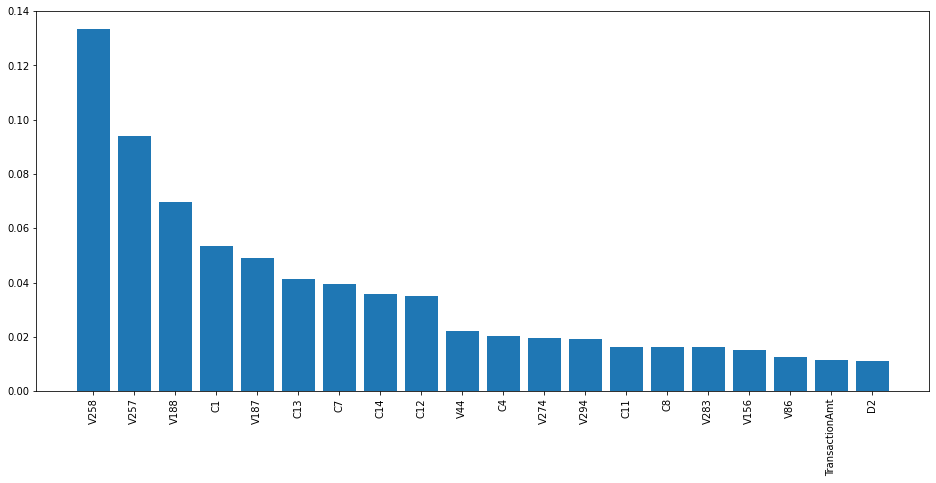

In [30]:
plt.figure(1, figsize=(16, 7))
plt.bar(imp.index, imp["Gini-importance"])
plt.xticks(imp.index, rotation=90)
print(imp.index)

In [31]:
from sklearn.model_selection import TimeSeriesSplit, KFold

n_folds = 5
folds = TimeSeriesSplit(n_splits=n_folds)
folds = KFold(n_splits=5)

In [32]:
columns = X_train.columns

splits = folds.split(X_train, y_train)

y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])

score_auc = 0

feature_importances = pd.DataFrame()
feature_importances["feature"] = columns

In [ ]:
print(f"\nMean AUC = {score_auc}")
print(f"Out of folds AUC = {roc_auc_score(y_train, y_oof)}")

In [50]:
%%time
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_tr, X_val = X_train[columns].iloc[train_index], X_train[columns].iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_tr, label=y_tr)
    dvalid = lgb.Dataset(X_val, label=y_val)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=100)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_val = clf.predict(X_val)
    y_oof[valid_index] = y_pred_val
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_val, y_pred_val)}")
    
    score_auc += roc_auc_score(y_val, y_pred_val) / n_folds
    
    y_preds += clf.predict(X_test) / n_folds
    
    del X_tr, X_val, y_tr, y_val

In [53]:
print(f"\nMean AUC = {score_auc}")
print(f"Out of folds AUC = {roc_auc_score(y_train, y_oof)}")


Mean AUC = 0.9141624311626435
Out of folds AUC = 0.9152769020220954


Index(['V258', 'V257', 'V188', 'C1', 'V187', 'C13', 'C7', 'C14', 'C12', 'V44',
       'C4', 'V274', 'V294', 'C11', 'C8', 'V283', 'V156', 'V86',
       'TransactionAmt', 'D2'],
      dtype='object')


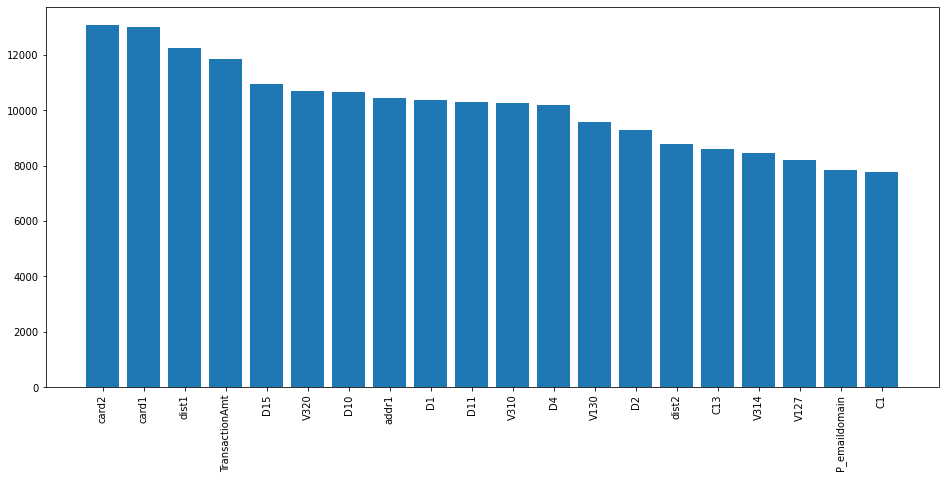

In [54]:
params = {
    "num_leaves": 64,
    "min_child_weight": 0.03,
    "feature_fraction": 0.04,
    "bagging_fraction": 0.33,
    "min_data_in_leaf": 80,
    "objective": "binary",
    "max_depth": -1,
    "learning_rate": 0.006,
    "boosting_type": "gbdt",
    "bagging_seed": 7,
    "metric": "auc",
    "verbosity": -1,
    "reg_alpha": 0.3,
    "reg_lambda": 0.6,
    "random_state": 0,
}

In [88]:
feature_importances["average"] = feature_importances[
    ["fold_{}".format(fold + 1) for fold in range(folds.n_splits)]
].mean(axis=1)

AttributeError: 'Booster' object has no attribute 'get_params'

In [52]:
f = (
    feature_importances[["feature", "average"]]
    .sort_values(by="average", ascending=False)
    .head(20)
)

In [ ]:
plt.figure(1, figsize=(16, 7))
plt.bar(f["feature"], f["average"])
plt.xticks(f["feature"], rotation=90)
print(imp.index)